In [10]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

In [2]:
def get_images(directory):
    intel_images = []
    intel_labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): # main Directory where each class label is present as folder name.
        if labels == 'glacier': # folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): # extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) # reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) # resizing the image
            intel_images.append(image)
            intel_labels.append(label)
    
    return shuffle(intel_images,intel_labels,random_state=817328462) # shuffle the dataset

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [3]:
intel_images, intel_labels = get_images('seg_train/seg_train/') # extract the training images from the folders
intel_images = np.array(intel_images) # converting the list of images to numpy array
intel_labels = np.array(intel_labels)

In [4]:
print("Shape of Images:", intel_images.shape)
print("Shape of Labels:", intel_labels.shape)

Shape of Images: (14034, 150, 150, 3)
Shape of Labels: (14034,)


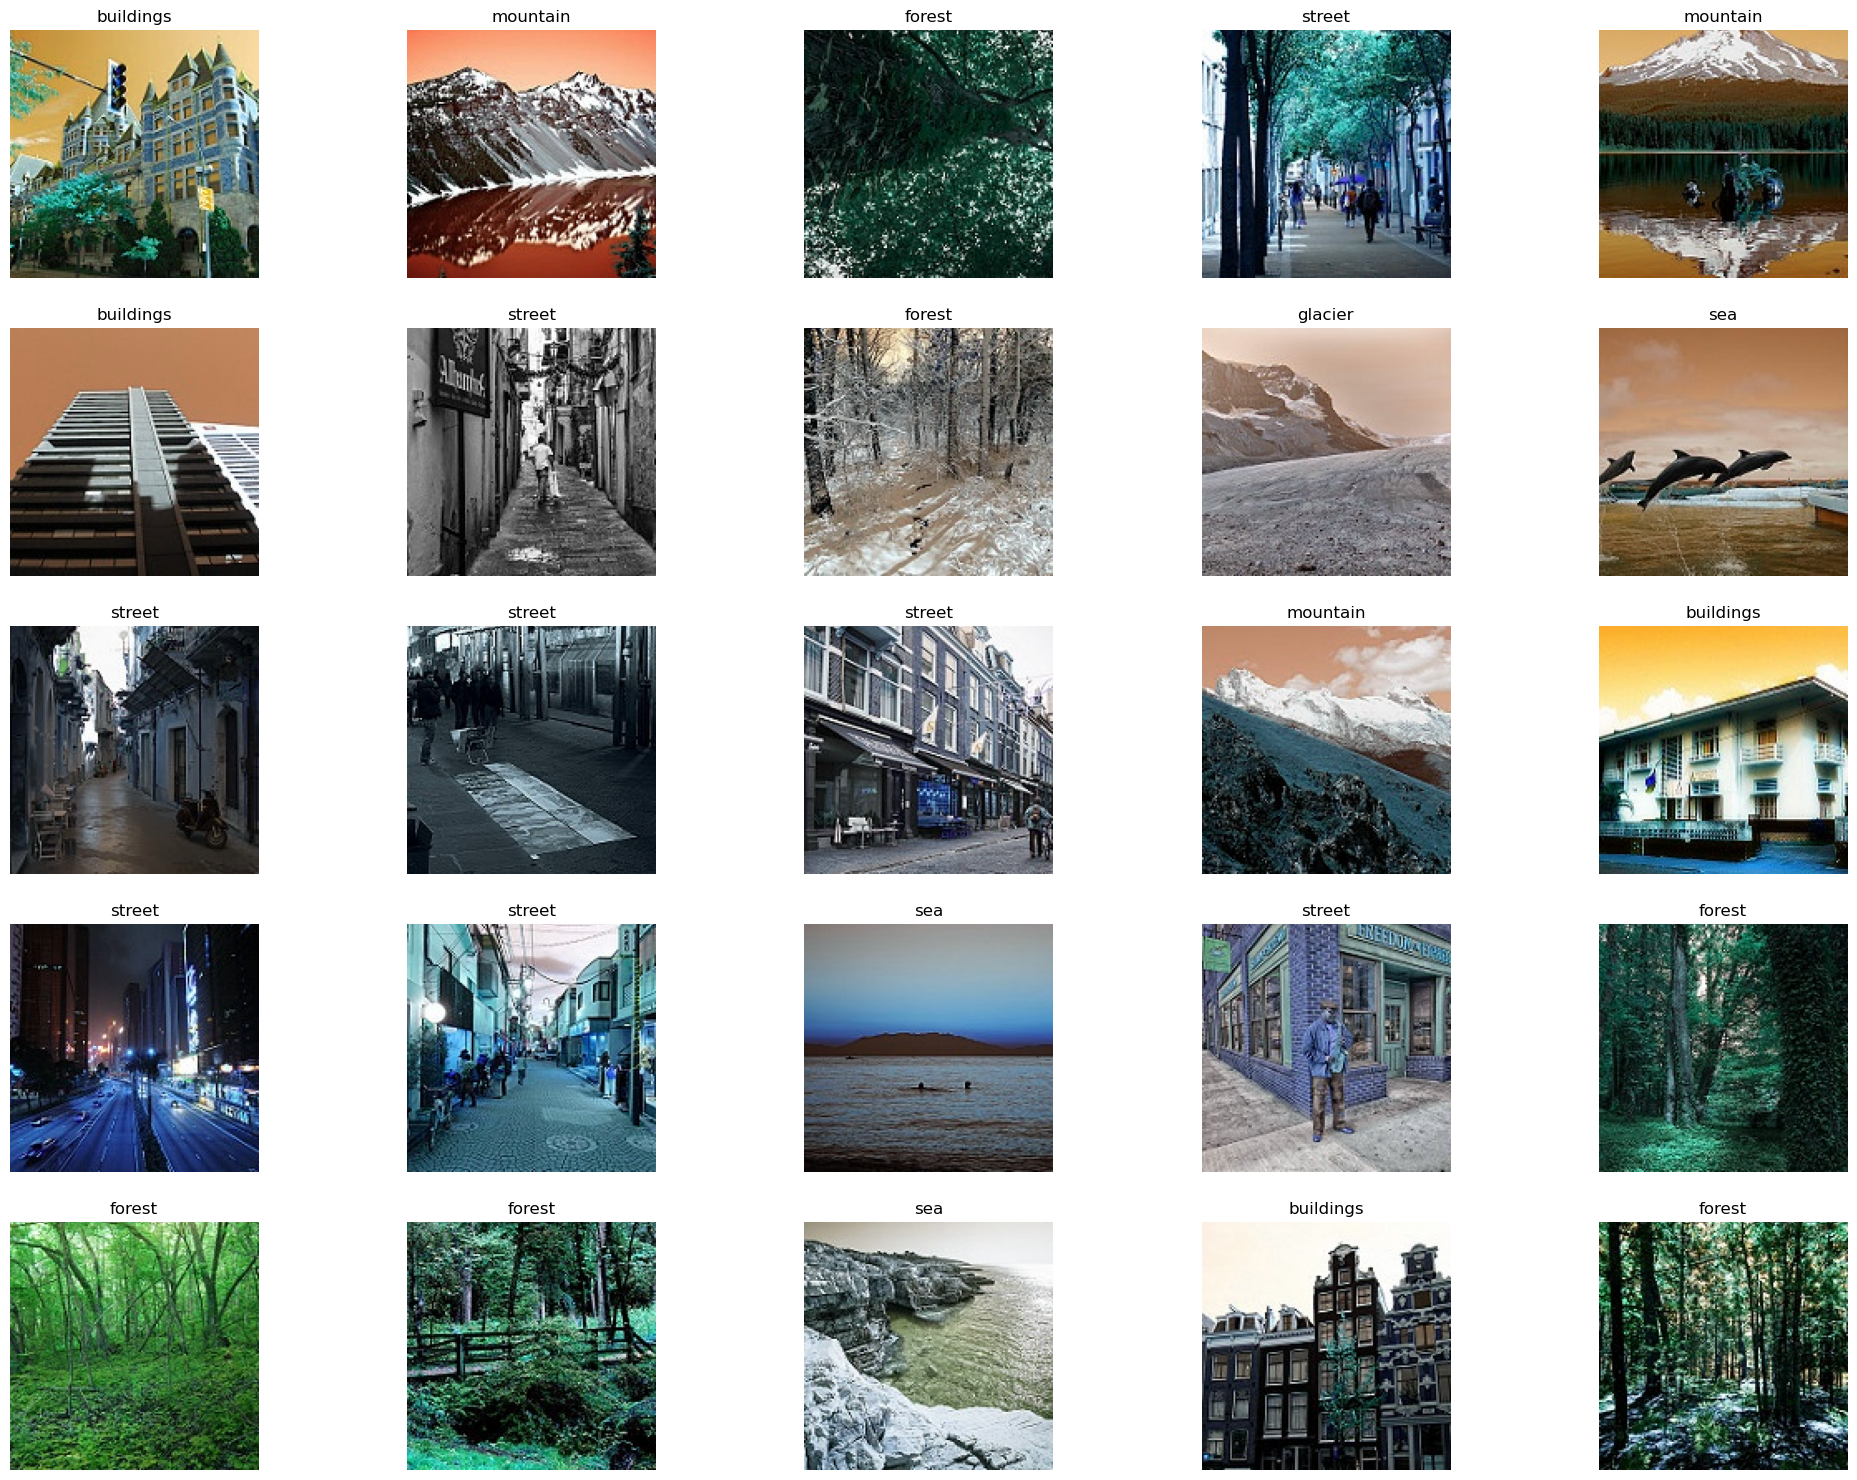

In [5]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(intel_images))
        ax[i,j].imshow(intel_images[rnd_number])
        ax[i,j].set_title(get_classlabel(intel_labels[rnd_number]))
        ax[i,j].axis('off')

In [11]:
model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 200)     5600      
                                                                 
 conv2d_13 (Conv2D)          (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 180)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 27, 27, 180)       291780    
                                                                 
 conv2d_15 (Conv2D)          (None, 25, 25, 140)       226940    
                                                                 
 conv2d_16 (Conv2D)          (None, 23, 23, 100)       126100    
                                                      

In [ ]:
trained = model.fit(intel_images, intel_labels, epochs=20, validation_split=0.30)

Epoch 1/20
 17/307 [>.............................] - ETA: 1:41:40 - loss: 4.8243 - accuracy: 0.1765

In [ ]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [ ]:
test_images,test_labels = get_images('seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

In [ ]:
pred_images,no_labels = get_images('seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)
fig.show()